# Neutron Star Class SPH Code

Source:

https://philip-mocz.medium.com/create-your-own-smoothed-particle-hydrodynamics-simulation-with-python-76e1cec505f1

https://github.com/zaman13/Modeling-of-Neutron-Stars/


In [157]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
import math
import matplotlib as mp
import scipy as sp
import pylab as py

from ipynb.fs.full.Neutron_Star_SPH_sph import W, gradW, getPairwiseSeparations, getDensity
from ipynb.fs.full.Neutron_Star_SPH_eos import EOS, initial_n, rho_NS

rho_s = 1665.3 #  Central density (density at r = 0)
hc = 197.327           # Conversion factor in MeV fm (hut * c) # hbar * c =1.9733×10−11 MeV cm...
G = hc * 6.67259e-45   # Gravitational constant
Ms = 1.1157467e60      # Mass of the sun in kg
mn = 938.926           # Mass of neutron in MeV c^-2

In [158]:
def EulerSolver(r,m,p,h,eos, flag = False):
    """ Euler Solver which iterates P and mass"""
    y = np.zeros(2)
    dp_dr = eos.dp_dr # extract the relevant dp_dr from the given EOS.
    dm_dr = eos.dm_dr 
    y[0] = m + dm_dr(r,m,p,flag)*h
    y[1] = p + dp_dr(r,m,p,flag)*h
    print(dp_dr(r,m,p,flag))
    return y

def getPressure(star):
    eos = star.eos
    rho = star.rho
    k = eos.constants["k"][0]
    n = eos.constants["n"][0]
    P = k * rho**(1+1/n)
    return P 

def getAcc(star):
    """ Calculate the acceleration on each SPH particle given current positions and velocities.
    
    'pos' contains particle coordinates (N x 3 matrix)
    'vel' contains particle velocities (N x 3 matrix)
    returns 'a' containing accelerations (another N x 3 matrix)
    
    m = particle mass, h = smoothing length, k = equation of state constant, n = polytropic index, lmbda = external force constant, nu = viscosity. 
    
    """ 
    eos = star.eos
    # Fixes: nu can come from the eos. I think h too. 
    nu = eos.constants["nu"][0]
    m = star.m
    h = star.h
    lmbda = eos.lmbda(star.mass, star.radius)
    
    # Exctract positions and velocities of points from the star
    pos = star.pos 
    vel = star.vel
    
    N = pos.shape[0] # Number of particles
    # I think you already did this and you can just use the star's density....
    rho = star.rho 
    P = getPressure(star) # Get the pressures corresponding to those densities
    dx, dy, dz = getPairwiseSeparations( pos, pos ) # Get pairwise distances
    dWx, dWy, dWz = gradW( dx, dy, dz, h )# Get pairwise gradients
    ax = - np.sum( m * ( np.transpose(P/rho**2) + P.T/rho.T**2 ) * dWx, 1).reshape((N,1)) # Add x Pressure contribution to accelerations
    ay = - np.sum( m * ( np.transpose(P/rho**2) + P.T/rho.T**2 ) * dWy, 1).reshape((N,1)) # Add y Pressure contribution to accelerations
    az = - np.sum( m * ( np.transpose(P/rho**2) + P.T/rho.T**2 ) * dWz, 1).reshape((N,1)) # Add z Pressure contribution to accelerations
    a = np.hstack((ax,ay,az)) # pack together the acceleration components
    
    ##### Extra forces
    a -= lmbda * pos # Add external potential force
    a -= nu * vel # Add viscosity
    return a

In [187]:
class NS:
    def __init__(self, tag, eos, mass = 1, radius = 1, num_points = 300):
        """
        NEUTRON STAR OBJECT
        
        A neutron star has the following attributes: 
            - tag, mass, radius, num_points  (eos?)
            
        A point has the following attributes: 
            - position (N x 3), vel (N x 3), acc (N x 3), density (N x 1), pressure (N x 1).        
        
        Goal: we want to give this star it's overall attributes and calculate the point attributes automatically.
        
        """
        #### INFO 
        self.tag = tag # "Name" of the star, just a string for identification
        self.radius = radius # star radius in km
        self.mass = mass # star mass in solar Masses
        self.eos = eos # equation of state
        self.radius_unit = 1 # if the radius of the star is given in units other than kilometers, you can give it a scale factor here.    
        self.num_points = num_points 
        self.m = mass/num_points # each point has mass m (maybe change later to baryon number)
        
        ################################################################
        ##### INITIALIZE STAR 
        # for each point in the star, initialize random positions and velocities.
        np.random.seed(42) # set the random number generator seed
        self.pos = np.random.randn(self.num_points,3)   # randomly select positions and velocit-ies from initialized seed
        self.vel = np.zeros(self.pos.shape)    # randomly select positions and velocities positions and velocities are N x 3 matrices.
        self.acc = np.zeros(self.pos.shape)  # initially we haven't updated the accelerations of those random points for the star.
        self.rho = None
        self.density = None
        ##### RELAXATION STEP --> RANDOM POINTS RELAX TO MATCH DENSITY
        dt = 0.05
        tEnd = 10
        N = num_points # Number of particles (redefined)
        M = mass # total star mass (Solar Masses) (redefined)
        R = radius # star radius (km) (redefined)
        k = eos.constants["k"][0] # equation of state constant
        n = eos.constants["n"][0] # polytropic index
        h = 0.05 # from previous results, this seems like a good smoothing length.
        self.h = h
        nu = 1 # damping
        lmbda = eos.lmbda(M,R)
        self.rho = getDensity(self.pos, self.pos, self.m, h) 
        
        t = 0      # current time of the simulation
        Nt = int(np.ceil(tEnd/dt)) # number of timesteps
        
        for i in range(Nt): # Star Simulation Time Iteration Main Loop
            self.vel += self.acc * dt/2 # (1/2) kick # adds acceleration
            self.pos += self.vel * dt # particle motion
            self.acc = getAcc(self) # get new Nx3 matrix of accelerations based on new pos,v
            self.vel += self.acc * dt/2 # (1/2) kick 
            t += dt # update time
            if t % dt*100==0: # print every 100 timesteps
                print("Star initialization.  timestep: " , t)
            self.rho = getDensity(self.pos, self.pos, self.m, h) # get updated density for each point based on m, h. 
        
        sd =  "\nSTAR OBJECT. Name: '" + self.tag + "', Mass: " + str(self.mass) + " SMs, "+ "Radius: " + str(self.radius*self.radius_unit) + " km" 
        print("-------success!\n", sd, "\n")
        return None
    
    
    def __str__(self):
        return "\nSTAR OBJECT. Name: '" + self.tag + "', Mass: " + str(self.mass) + " SMs, "+ "Radius: " + str(self.radius*self.radius_unit) + " km" 
    
    def update(self): 
        """ This function will update the positions of the points for one timestep 
        based on the force acting on the center of gravity of the star. 
        
        The points of one star only recieve center of gravity info and react to each other
        They do not interact directly with the points of the other star.
        
        """
        return None





def plot(stars,x_lim = 50, y_lim = 50,fig_size=(4,5), dpi_ = 300, gridspecs=[3,1], fig=None, ax=None, density_plot = False):
    """ Takes in any number of stas and plots their points. """
    if fig == None: 
        fig = plt.figure(figsize=fig_size, dpi=dpi_)
        grid = plt.GridSpec(gridspecs[0], gridspecs[1], wspace=0.0, hspace=0.3)
    if ax == None:
        ax1 = plt.subplot(grid[0:2,0])
        if density_plot:
            ax2 = plt.subplot(grid[2,0])# for second plot

        
    rr = np.zeros((100,3))
    rlin = np.linspace(0,1,100)
    rr[:,0] =rlin
    plt.sca(ax1)
    plt.cla()
    title = ""
    for i in range(len(stars)):
        star = stars[i]
        pos = star.pos + i*4 # shifted the positions of the second star...
        rho = star.rho
        cval = np.minimum((rho-3)/3,1).flatten()
        plt.scatter(pos[:,0],pos[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.5)
        title = title + str(star)
        
    ax1.set(xlim=(-x_lim, x_lim), ylim=(-y_lim, y_lim))
    ax1.set_aspect('equal', 'box')
    ax1.set_facecolor('black')
    ax1.set_facecolor((.1,.1,.1))

    plt.title(str(title))
    plt.xlabel("km")
    plt.ylabel("km")
    
# # density plot
#     rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)
#     if density_plot:
#         plt.sca(ax2)
#         plt.cla()
#         ax2.set(xlim=(0, 1), ylim=(0, 3))
#         ax2.set_aspect(0.1)
#         plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
#         rho_radial = getDensity( rr, pos, m, h )
#         plt.plot(rlin, rho_radial, color='blue')
#         plt.pause(0.001)
    return None



In [188]:
myEOS = EOS('standard') # create an equation of state object

myNS = NS("my Neutron star 1", myEOS,0.5,0.5)
myNS2 = NS("my Neutron star 2", myEOS,2,1) # double the mass and radius of the first star

Star initialization.  timestep:  0.05
Star initialization.  timestep:  0.1
Star initialization.  timestep:  0.2
-------success!
 
STAR OBJECT. Name: 'my Neutron star 1', Mass: 0.5 SMs, Radius: 0.5 km 

Star initialization.  timestep:  0.05
Star initialization.  timestep:  0.1
Star initialization.  timestep:  0.2
-------success!
 
STAR OBJECT. Name: 'my Neutron star 2', Mass: 2 SMs, Radius: 1 km 



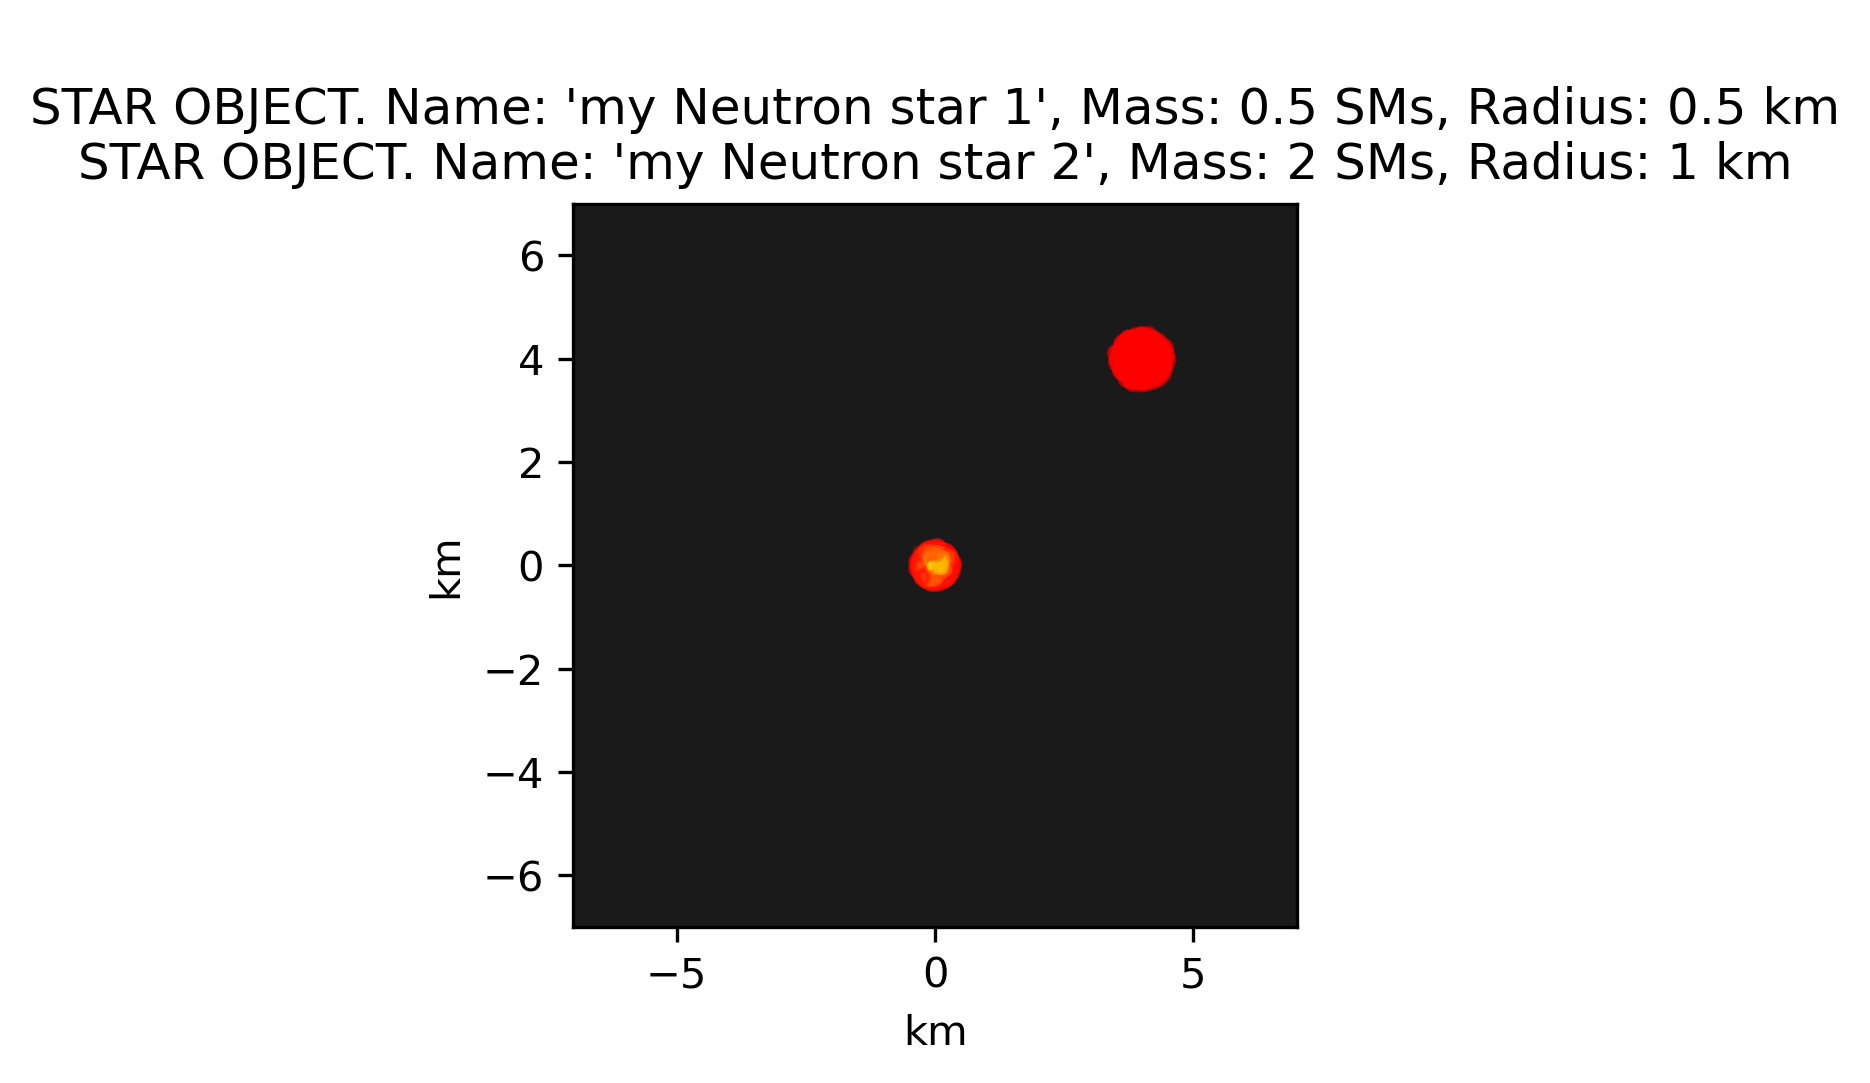

In [189]:
ns1 = [myNS]
ns2 = [myNS2]
both = [myNS, myNS2]
plot(both, 7,7)